In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import f1_score,confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from datetime import datetime
from xgboost import XGBClassifier

In [3]:
Fraud_data=pd.read_csv("Fraud_Data.csv")
IpAddress=pd.read_csv("IpAddress_to_Country.csv")

In [3]:
Fraud_data.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0


In [4]:
Fraud_data.shape

(151112, 11)

In [5]:
Fraud_data.describe(include="all")

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
count,151112.000000,151112,151112,151112.000000,151112,151112,151112,151112,151112.000000,1.511120e+05,151112.000000
unique,NaN,151112,150679,NaN,137956,3,5,2,NaN,NaN,NaN
top,NaN,2015-01-04 08:30:03,2015-09-10 09:04:53,NaN,KIPFSCNUGOLDP,SEO,Chrome,M,NaN,NaN,NaN
freq,NaN,1,3,NaN,20,60615,61432,88293,NaN,NaN,NaN
mean,200171.040970,NaN,NaN,36.935372,NaN,NaN,NaN,NaN,33.140704,2.152145e+09,0.093646
std,115369.285024,NaN,NaN,18.322762,NaN,NaN,NaN,NaN,8.617733,1.248497e+09,0.291336
min,2.000000,NaN,NaN,9.000000,NaN,NaN,NaN,NaN,18.000000,5.209350e+04,0.000000
25%,100642.500000,NaN,NaN,22.000000,NaN,NaN,NaN,NaN,27.000000,1.085934e+09,0.000000
50%,199958.000000,NaN,NaN,35.000000,NaN,NaN,NaN,NaN,33.000000,2.154770e+09,0.000000
75%,300054.000000,NaN,NaN,49.000000,NaN,NaN,NaN,NaN,39.000000,3.243258e+09,0.000000


In [6]:
Fraud_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151112 entries, 0 to 151111
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   user_id         151112 non-null  int64  
 1   signup_time     151112 non-null  object 
 2   purchase_time   151112 non-null  object 
 3   purchase_value  151112 non-null  int64  
 4   device_id       151112 non-null  object 
 5   source          151112 non-null  object 
 6   browser         151112 non-null  object 
 7   sex             151112 non-null  object 
 8   age             151112 non-null  int64  
 9   ip_address      151112 non-null  float64
 10  class           151112 non-null  int64  
dtypes: float64(1), int64(4), object(6)
memory usage: 12.7+ MB


In [16]:
Fraud_data["class"].value_counts(normalize=True)

0    0.906354
1    0.093646
Name: class, dtype: float64

In [13]:
IpAddress.head(10)

,lower_bound_ip_address,upper_bound_ip_address,country
0,16777216.0,16777471,Australia
1,16777472.0,16777727,China
2,16777728.0,16778239,China
3,16778240.0,16779263,Australia
4,16779264.0,16781311,China
5,16781312.0,16785407,Japan
6,16785408.0,16793599,China
7,16793600.0,16809983,Japan
8,16809984.0,16842751,Thailand
9,16842752.0,16843007,China


In [14]:
IpAddress.shape

(138846, 3)

In [105]:
# function that takes an IP address as argument and returns country associated based on IP_table
def ip_to_country(ip=None):
    try :
        return IpAddress.country[(IpAddress.lower_bound_ip_address <= ip) 
                             & (IpAddress.upper_bound_ip_address >= ip)].iloc[0]
    except IndexError :
        return "Unknown"     
# To affect a country to each IP :
Fraud_data["ip_country"] = Fraud_data.ip_address.apply(ip_to_country)

In [108]:
Fraud_data.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,ip_country
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,Unknown
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States


In [110]:
Fraud_data.ip_country.value_counts()

United States                     58049
Unknown                           21966
China                             12038
Japan                              7306
United Kingdom                     4490
                                  ...  
Myanmar                               1
South Sudan                           1
Guadeloupe                            1
British Indian Ocean Territory        1
Turkmenistan                          1
Name: ip_country, Length: 182, dtype: int64

### Réduction aux features les plus simples du dataset

In [18]:
Fraud_data.columns

Index(['user_id', 'signup_time', 'purchase_time', 'purchase_value',
       'device_id', 'source', 'browser', 'sex', 'age', 'ip_address', 'class'],
      dtype='object')

In [20]:
Fraud_redux=Fraud_data[['purchase_value', 'source', 'browser', 'sex', 'age', 'class']]
dataset.head()

,purchase_value,source,browser,sex,age,class
0,34,SEO,Chrome,M,39,0
1,16,Ads,Chrome,F,53,0
2,15,SEO,Opera,M,53,1
3,44,SEO,Safari,M,41,0
4,39,Ads,Safari,M,45,0


In [21]:
Fraud_redux.corr()

,purchase_value,age,class
purchase_value,1.000000,0.002370,0.001011
age,0.002370,1.000000,0.006624
class,0.001011,0.006624,1.000000


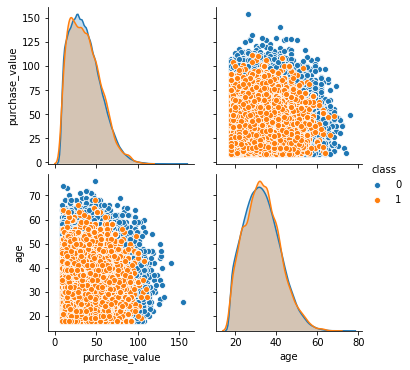

In [22]:
sns.pairplot(Fraud_redux, hue="class")

In [69]:
# Séparation des variables
features_list = ['purchase_value', 'source', 'browser', 'sex', 'age']
numeric_indices = [0,4]
categorical_indices = [1,2,3]
target_variable = 'class'
X = Fraud_redux.loc[:, features_list]
y = Fraud_redux.loc[:, target_variable]

In [70]:
# Divide dataset Train set & Test set 
print("Dividing into train and test sets...")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)
print("...Done.")

Dividing into train and test sets...
...Done.


In [71]:
# Convert pandas DataFrames to numpy arrays before using scikit-learn
print("Convert pandas DataFrames to numpy arrays...")
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values
print("...Done")

Convert pandas DataFrames to numpy arrays...
...Done


In [72]:
# Preprocessings
print("Encoding categorical features and standardizing numerical features...")

# Normalization
numeric_transformer = StandardScaler()

# OHE / dummyfication
categorical_transformer = OneHotEncoder(drop='first')


featureencoder = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_indices),    
        ('num', numeric_transformer, numeric_indices)
        ])
X_train = featureencoder.fit_transform(X_train)

#feature encoding on test set
X_test = featureencoder.transform(X_test)
print("...Done")
print(X_train[0:3,:])


Encoding categorical features and standardizing numerical features...
...Done
[[ 1.          0.          0.          0.          0.          1.
   0.         -0.86792715  0.67834581]
 [ 0.          1.          0.          0.          0.          1.
   1.         -0.9224847  -0.94523103]
 [ 0.          0.          0.          0.          0.          1.
   1.         -0.15867899 -0.82926125]]


### Fitting a basic model to have a baseline

In [73]:
# basic classification with a decision tree
tree=DecisionTreeClassifier()
tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)
print("f1-score on train set : ", f1_score(y_train, y_train_pred))
print("f1-score on test set : ", f1_score(y_test, y_test_pred))

f1-score on train set :  0.6651260926353864
f1-score on test set :  0.5116366366366367


In [74]:
# basic classification with a Random Forest
rf = RandomForestClassifier(n_jobs=-1)
rf.fit(X_train, y_train)
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)
print("f1-score on train set : ", f1_score(y_train, y_train_pred))
print("f1-score on test set : ", f1_score(y_test, y_test_pred))

f1-score on train set :  0.6714609398088859
f1-score on test set :  0.5410440520085388


In [ ]:
rf = RandomForestClassifier(n_jobs=-1)

params = {
    'bootstrap': [True],
    'max_depth': [60, 80, 100],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300]}

GridSearch = GridSearchCV(cv=5,
                          estimator = rf,
                        param_grid = params,
                         scoring= "f1",
                         n_jobs=-1,
                         verbose=2).fit(X_train, y_train)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


### Utilisation des données Time

In [3]:
Fraud_data.columns

Index(['user_id', 'signup_time', 'purchase_time', 'purchase_value',
       'device_id', 'source', 'browser', 'sex', 'age', 'ip_address', 'class'],
      dtype='object')

In [4]:
dataset=Fraud_data[['signup_time', 'purchase_time','purchase_value', 'source', 'browser', 'sex', 'age', 'class']]
dataset.head()

,signup_time,purchase_time,purchase_value,source,browser,sex,age,class
0,2015-02-24 22:55:49,2015-04-18 02:47:11,34,SEO,Chrome,M,39,0
1,2015-06-07 20:39:50,2015-06-08 01:38:54,16,Ads,Chrome,F,53,0
2,2015-01-01 18:52:44,2015-01-01 18:52:45,15,SEO,Opera,M,53,1
3,2015-04-28 21:13:25,2015-05-04 13:54:50,44,SEO,Safari,M,41,0
4,2015-07-21 07:09:52,2015-09-09 18:40:53,39,Ads,Safari,M,45,0


In [5]:
# change the date format in order to calculate the time lapse betwwen sign up and purchase
format="%Y-%m-%d %H:%M:%S"
deltatime=[]
for i in range(len(dataset.signup_time)) :
    time_sign=datetime.strptime(dataset.signup_time[i],format)
    time_purch=datetime.strptime(dataset.purchase_time[i],format)
    delta=(time_purch-time_sign).total_seconds()
    deltatime.append(delta)

In [6]:
dataset["DeltaTime"]=np.array(deltatime)

C:\Users\mciro\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [12]:
dataset.describe()

,purchase_value,age,class,DeltaTime
count,151112.000000,151112.000000,151112.000000,1.511120e+05
mean,36.935372,33.140704,0.093646,4.932029e+06
std,18.322762,8.617733,0.291336,3.126263e+06
min,9.000000,18.000000,0.000000,1.000000e+00
25%,22.000000,27.000000,0.000000,2.186754e+06
50%,35.000000,33.000000,0.000000,4.926346e+06
75%,49.000000,39.000000,0.000000,7.644524e+06
max,154.000000,76.000000,1.000000,1.036797e+07


In [22]:
dataset[dataset.DeltaTime <=1]

,signup_time,purchase_time,purchase_value,source,browser,sex,age,class,DeltaTime
2,2015-01-01 18:52:44,2015-01-01 18:52:45,15,SEO,Opera,M,53,1,1.0
24,2015-01-11 01:51:15,2015-01-11 01:51:16,52,Direct,IE,F,35,1,1.0
29,2015-01-07 03:44:53,2015-01-07 03:44:54,48,SEO,Chrome,F,27,1,1.0
64,2015-01-07 17:45:16,2015-01-07 17:45:17,10,Ads,FireFox,M,36,1,1.0
77,2015-01-07 08:15:53,2015-01-07 08:15:54,65,SEO,Opera,F,30,1,1.0
...,...,...,...,...,...,...,...,...,...
151036,2015-01-03 12:52:15,2015-01-03 12:52:16,38,Ads,Chrome,M,27,1,1.0
151082,2015-01-07 09:06:55,2015-01-07 09:06:56,90,SEO,IE,M,34,1,1.0
151099,2015-01-01 07:26:14,2015-01-01 07:26:15,61,Direct,IE,M,24,1,1.0
151103,2015-01-04 23:03:04,2015-01-04 23:03:05,27,Direct,Chrome,M,39,1,1.0


In [ ]:
sns.barplot(x="class", y="DeltaTime")

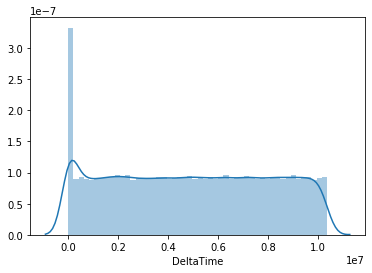

In [17]:
sns.distplot(dataset.DeltaTime)

In [25]:
DayofWeek=[]
for i in range(len(dataset.purchase_time)):
    time_purch=datetime.strptime(dataset.purchase_time[i],format)
    day_purch=datetime.weekday(time_purch)
    DayofWeek.append(day_purch)
dataset["DayofWeek"]=np.array(DayofWeek)

C:\Users\mciro\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [112]:
dataset.DayofWeek=dataset.DayofWeek.map({"Lundi" :0,
                                            "Mardi":1,
                                            "Mercredi":2,
                                            "Jeudi":3,
                                            "Vendredi":4,
                                            "Samedi":5,
                                            "Dimanche":6})

In [27]:
HourofDay=[]
for i in range(len(dataset.purchase_time)):
    time_purch=datetime.strptime(dataset.purchase_time[i],format)
    Hour_purch=time_purch.hour
    HourofDay.append(Hour_purch)
dataset["HourofDay"]=np.array(HourofDay)

In [113]:
dataset.head()

,signup_time,purchase_time,purchase_value,source,browser,sex,age,class,DeltaTime,DayofWeek,HourofDay
0,2015-02-24 22:55:49,2015-04-18 02:47:11,34,SEO,Chrome,M,39,0,4506682.0,5,2
1,2015-06-07 20:39:50,2015-06-08 01:38:54,16,Ads,Chrome,F,53,0,17944.0,0,1
2,2015-01-01 18:52:44,2015-01-01 18:52:45,15,SEO,Opera,M,53,1,1.0,3,18
3,2015-04-28 21:13:25,2015-05-04 13:54:50,44,SEO,Safari,M,41,0,492085.0,0,13
4,2015-07-21 07:09:52,2015-09-09 18:40:53,39,Ads,Safari,M,45,0,4361461.0,2,18


In [114]:
dataset.groupby("class").mean()

,purchase_value,age,DeltaTime,DayofWeek,HourofDay
class,,,,,
0,36.929418,33.122356,5.191179e+06,2.999606,11.517249
1,36.993004,33.318281,2.423842e+06,3.130026,11.563635


In [33]:
dataset.describe(include="all")

,signup_time,purchase_time,purchase_value,source,browser,sex,age,class,DeltaTime,DayofWeek,HourofDay
count,151112,151112,151112.000000,151112,151112,151112,151112.000000,151112.000000,1.511120e+05,151112,151112.000000
unique,151112,150679,NaN,3,5,2,NaN,NaN,NaN,7,NaN
top,2015-01-10 18:43:30,2015-07-17 23:22:55,NaN,SEO,Chrome,M,NaN,NaN,NaN,Dimanche,NaN
freq,1,3,NaN,60615,61432,88293,NaN,NaN,NaN,22015,NaN
mean,NaN,NaN,36.935372,NaN,NaN,NaN,33.140704,0.093646,4.932029e+06,NaN,11.521593
std,NaN,NaN,18.322762,NaN,NaN,NaN,8.617733,0.291336,3.126263e+06,NaN,6.912474
min,NaN,NaN,9.000000,NaN,NaN,NaN,18.000000,0.000000,1.000000e+00,NaN,0.000000
25%,NaN,NaN,22.000000,NaN,NaN,NaN,27.000000,0.000000,2.186754e+06,NaN,6.000000
50%,NaN,NaN,35.000000,NaN,NaN,NaN,33.000000,0.000000,4.926346e+06,NaN,12.000000
75%,NaN,NaN,49.000000,NaN,NaN,NaN,39.000000,0.000000,7.644524e+06,NaN,17.000000


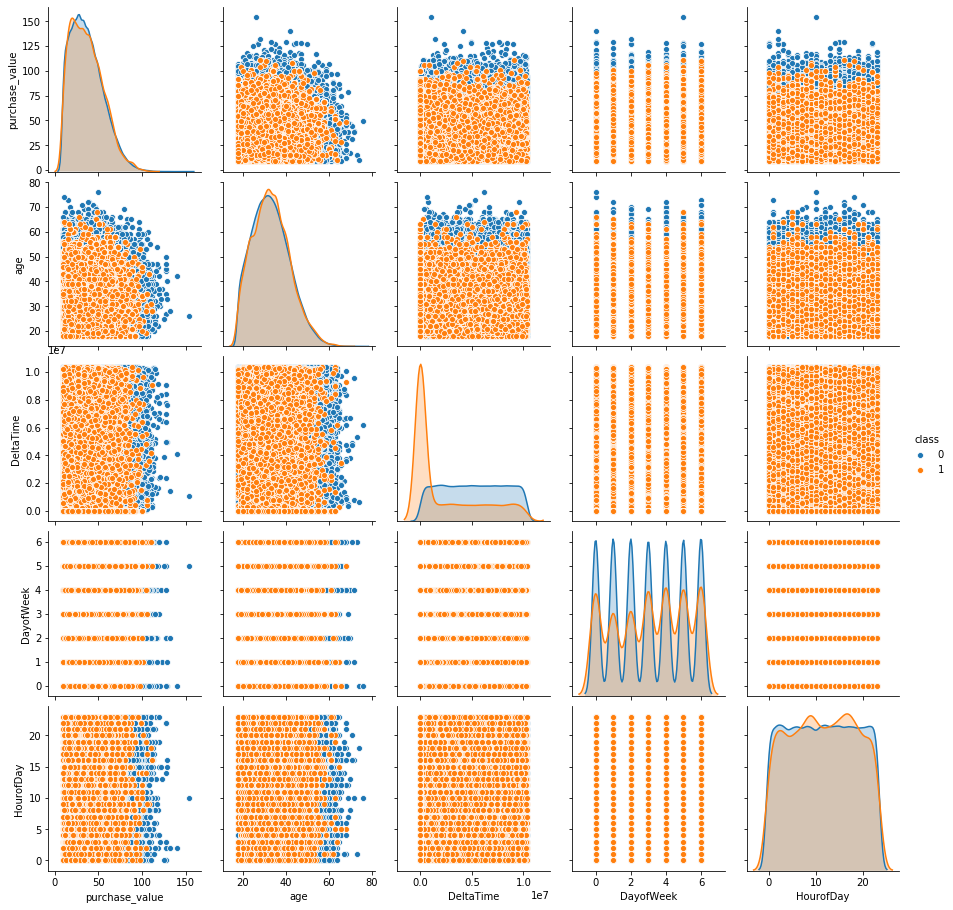

In [115]:
sns.pairplot(dataset, hue="class")

In [75]:
dataset.columns

Index(['signup_time', 'purchase_time', 'purchase_value', 'source', 'browser',
       'sex', 'age', 'class', 'DeltaTime', 'DayofWeek', 'HourofDay'],
      dtype='object')

### Model including all the features

In [88]:
features_list = ['purchase_value', 'source', 'browser', 'sex', 'age','DeltaTime', 'DayofWeek','HourofDay']
numeric_indices = [0,4,5]
categorical_indices = [1,2,3,6,7]
target_variable = 'class'

X = dataset.loc[:, features_list]
y = dataset.loc[:, target_variable]

print("Dividing into train and test sets...")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)
print("...Done.")

print("Convert pandas DataFrames to numpy arrays...")
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values
print("...Done")

print("Encoding categorical features and standardizing numerical features...")

numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(drop='first')
featureencoder = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_indices),    
        ('num', numeric_transformer, numeric_indices)
        ])
X_train = featureencoder.fit_transform(X_train)
print("...Done")

X_test = featureencoder.transform(X_test)



Dividing into train and test sets...
...Done.
Convert pandas DataFrames to numpy arrays...
...Done
Encoding categorical features and standardizing numerical features...
...Done


In [116]:
print("...Training the model")
clf = RandomForestClassifier(n_jobs=-1, criterion="entropy")
clf.fit(X_train, y_train)
print("...Done")

print("Predictions on test set...")
y_test_pred = clf.predict(X_test)
print("...Done.")
y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)
print("f1-score on train set : ", f1_score(y_train, y_train_pred))
print("f1-score on test set : ", f1_score(y_test, y_test_pred))

cm_train=confusion_matrix(y_train, y_train_pred)
print(cm_train)
cm_test=confusion_matrix(y_test, y_test_pred)
print(cm_test)

...Training the model
...Done
Predictions on test set...
...Done.
f1-score on train set :  0.999337075175675
f1-score on test set :  0.6301479408236705
[[109568      0]
 [    15  11306]]
[[26797   596]
 [ 1254  1576]]


#### Major overfitting !!! let's try XGBOOST

In [89]:
xgb = XGBClassifier(n_jobs=-1)
xgb.fit(X_train, y_train)
y_train_pred = xgb.predict(X_train)
y_test_pred = xgb.predict(X_test)
print("f1-score on train set : ", f1_score(y_train, y_train_pred))
print("f1-score on test set : ", f1_score(y_test, y_test_pred))


f1-score on train set :  0.6976877947774072
f1-score on test set :  0.7089416058394161


### Reducing features in order to reduce overfitting

In [ ]:
features_list = ['purchase_value', 'source', 'browser', 'sex', 'age','DeltaTime', 'DayofWeek']
numeric_indices = [0,4,5]
categorical_indices = [1,2,3,6]
target_variable = 'class'

X = dataset.loc[:, features_list]
y = dataset.loc[:, target_variable]

print("Dividing into train and test sets...")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)
print("...Done.")

print("Convert pandas DataFrames to numpy arrays...")
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values
print("...Done")

print("Encoding categorical features and standardizing numerical features...")

numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(drop='first')
featureencoder = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_indices),    
        ('num', numeric_transformer, numeric_indices)
        ])
X_train = featureencoder.fit_transform(X_train)
print("...Done")

X_test = featureencoder.transform(X_test)

print("...Training the model")
clf = RandomForestClassifier(n_jobs=-1, criterion="entropy")
clf.fit(X_train, y_train)
print("...Done")

print("Predictions on test set...")
y_test_pred = clf.predict(X_test)
print("...Done.")
y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)
print("f1-score on train set : ", f1_score(y_train, y_train_pred))
print("f1-score on test set : ", f1_score(y_test, y_test_pred))

cm_train=confusion_matrix(y_train, y_train_pred)
print(cm_train)
cm_test=confusion_matrix(y_test, y_test_pred)
print(cm_test)

In [68]:
features_list = ['purchase_value', 'source', 'browser', 'sex', 'age','DeltaTime']
numeric_indices = [0,4,5]
categorical_indices = [1,2,3]
target_variable = 'class'

X = dataset.loc[:, features_list]
y = dataset.loc[:, target_variable]

print("Dividing into train and test sets...")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)
print("...Done.")

print("Convert pandas DataFrames to numpy arrays...")
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values
print("...Done")

print("Encoding categorical features and standardizing numerical features...")

numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(drop='first')
featureencoder = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_indices),    
        ('num', numeric_transformer, numeric_indices)
        ])
X_train = featureencoder.fit_transform(X_train)
print("...Done")

X_test = featureencoder.transform(X_test)

print("...Training the model")
clf = RandomForestClassifier(n_jobs=-1, criterion="entropy")
clf.fit(X_train, y_train)
print("...Done")

print("Predictions on test set...")
y_test_pred = clf.predict(X_test)
print("...Done.")
y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)
print("f1-score on train set : ", f1_score(y_train, y_train_pred))
print("f1-score on test set : ", f1_score(y_test, y_test_pred))

cm_train=confusion_matrix(y_train, y_train_pred)
print(cm_train)
cm_test=confusion_matrix(y_test, y_test_pred)
print(cm_test)

Dividing into train and test sets...
...Done.
Convert pandas DataFrames to numpy arrays...
...Done
Encoding categorical features and standardizing numerical features...
...Done
...Training the model
...Done
Predictions on test set...
...Done.
f1-score on train set :  0.9995581477553905
f1-score on test set :  0.7028248587570622
[[109568      0]
 [    10  11311]]
[[27353    40]
 [ 1275  1555]]


In [69]:
features_list = ['purchase_value', 'source', 'browser','DeltaTime']
numeric_indices = [0,3]
categorical_indices = [1,2]
target_variable = 'class'

X = dataset.loc[:, features_list]
y = dataset.loc[:, target_variable]

print("Dividing into train and test sets...")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)
print("...Done.")

print("Convert pandas DataFrames to numpy arrays...")
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values
print("...Done")

print("Encoding categorical features and standardizing numerical features...")

numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(drop='first')
featureencoder = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_indices),    
        ('num', numeric_transformer, numeric_indices)
        ])
X_train = featureencoder.fit_transform(X_train)
print("...Done")

X_test = featureencoder.transform(X_test)

print("...Training the model")
clf = RandomForestClassifier(n_jobs=-1, criterion="entropy")
clf.fit(X_train, y_train)
print("...Done")

print("Predictions on test set...")
y_test_pred = clf.predict(X_test)
print("...Done.")
y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)
print("f1-score on train set : ", f1_score(y_train, y_train_pred))
print("f1-score on test set : ", f1_score(y_test, y_test_pred))

cm_train=confusion_matrix(y_train, y_train_pred)
print(cm_train)
cm_test=confusion_matrix(y_test, y_test_pred)
print(cm_test)

Dividing into train and test sets...
...Done.
Convert pandas DataFrames to numpy arrays...
...Done
Encoding categorical features and standardizing numerical features...
...Done
...Training the model
...Done
Predictions on test set...
...Done.
f1-score on train set :  0.9992486187845304
f1-score on test set :  0.6344216041918581
[[109568      0]
 [    17  11304]]
[[26835   558]
 [ 1256  1574]]


Pas d'amélioration dans l'overfitting en réduisant le nombre de features...

### Using XGBOOST and ADABOOST on  a reduced set of features

In [100]:
features_list = ['purchase_value', 'source', 'browser','DeltaTime']
numeric_indices = [0,3]
categorical_indices = [1,2]
target_variable = 'class'

X = dataset.loc[:, features_list]
y = dataset.loc[:, target_variable]

print("Dividing into train and test sets...")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)
print("...Done.")

print("Convert pandas DataFrames to numpy arrays...")
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values
print("...Done")

print("Encoding categorical features and standardizing numerical features...")

numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(drop='first')
featureencoder = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_indices),    
        ('num', numeric_transformer, numeric_indices)
        ])
X_train = featureencoder.fit_transform(X_train)
print("...Done")

X_test = featureencoder.transform(X_test)

Dividing into train and test sets...
...Done.
Convert pandas DataFrames to numpy arrays...
...Done
Encoding categorical features and standardizing numerical features...
...Done


In [101]:
from xgboost import XGBClassifier
xgb = XGBClassifier(n_jobs=-1)
xgb.fit(X_train, y_train)
y_train_pred = xgb.predict(X_train)
y_test_pred = xgb.predict(X_test)
print("f1-score on train set : ", f1_score(y_train, y_train_pred))
print("f1-score on test set : ", f1_score(y_test, y_test_pred))

f1-score on train set :  0.6968633093525181
f1-score on test set :  0.7089416058394161


In [102]:
cm_train=confusion_matrix(y_train, y_train_pred)
print(cm_train)
cm_test=confusion_matrix(y_test, y_test_pred)
print(cm_test)

[[109568      0]
 [  5267   6054]]
[[27393     0]
 [ 1276  1554]]


In [103]:
from sklearn.ensemble import AdaBoostClassifier
ada=AdaBoostClassifier()
ada.fit(X_train, y_train)
y_train_pred = ada.predict(X_train)
y_test_pred = ada.predict(X_test)
print("f1-score on train set : ", f1_score(y_train, y_train_pred))
print("f1-score on test set : ", f1_score(y_test, y_test_pred))

f1-score on train set :  0.6964131498647015
f1-score on test set :  0.7087799315849487


In [104]:
cm_train=confusion_matrix(y_train, y_train_pred)
print(cm_train)
cm_test=confusion_matrix(y_test, y_test_pred)
print(cm_test)

[[109568      0]
 [  5273   6048]]
[[27392     1]
 [ 1276  1554]]


### Using XGBOOST with just one features (elapsed time) give almost the same result

In [7]:
features_list = ['DeltaTime']
numeric_indices = [0]
categorical_indices = []
target_variable = 'class'

X = dataset.loc[:, features_list]
y = dataset.loc[:, target_variable]

print("Dividing into train and test sets...")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)
print("...Done.")

print("Convert pandas DataFrames to numpy arrays...")
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values
print("...Done")

print("Encoding categorical features and standardizing numerical features...")

numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(drop='first')
featureencoder = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_indices),    
        ('num', numeric_transformer, numeric_indices)
        ])
X_train = featureencoder.fit_transform(X_train)
print("...Done")

X_test = featureencoder.transform(X_test)

Dividing into train and test sets...
...Done.
Convert pandas DataFrames to numpy arrays...
...Done
Encoding categorical features and standardizing numerical features...
...Done


In [8]:
from xgboost import XGBClassifier
xgb = XGBClassifier(n_jobs=-1)
xgb.fit(X_train, y_train)
y_train_pred = xgb.predict(X_train)
y_test_pred = xgb.predict(X_test)
print("f1-score on train set : ", f1_score(y_train, y_train_pred))
print("f1-score on test set : ", f1_score(y_test, y_test_pred))

f1-score on train set :  0.6964881980426022
f1-score on test set :  0.7087799315849487
